# Lecture 07: Raster math and sampling rasters




In [1]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import rasterio as rio
import rasterio.plot # Necessary to use rio.plot.show()
import richdem as rd

import geopandas as gpd
import fiona


In [2]:
Path('.')

# if Path('../../datasets')
datasets_dir = Path('../../datasets')

lidar_dem_path = datasets_dir / 'moscow' / 'moscow_lidar_elevation' / 'City_of_Moscow_LiDAR.vrt'


In [3]:
# elev_rio = rio.open(lidar_dem_path)
elev_rio = rio.open(datasets_dir / 'regional_dems' / 'palouse_hills.tif')
# elev_rio = rio.open('palouse_hills_re.tif')

# # Another option, for reading right into richdem
# elev_rd = rd.LoadGDAL('../../datasets/moscow/moscow_lidar_elevation/City_of_Moscow_LiDAR.vrt')

In [4]:
type(elev_rio)

rasterio.io.DatasetReader

In [5]:
elev = elev_rio.read(1)
elev[elev<-1000] = np.nan

In [6]:
type(elev)

numpy.ndarray

In [7]:
# dir(elev_rio)
# elev_rio.units
print(elev_rio.crs)

elev_rio.transform # The `transform` orients the raster grid in space relative to the crs.
    # The crs contains the units and identifies where the (0, 0) point of the grid ought to be in space.

EPSG:4269


Affine(9.259259284609841e-05, 0.0, -117.29564814622064,
       0.0, -9.259259284609902e-05, 46.83527777766481)

In [8]:
1/60/60/3

9.259259259259259e-05

In [9]:
dx = elev_rio.transform[0] # grid resolution in Easting (x)
rast_x = elev_rio.transform[2] + dx * np.arange(elev_rio.width)
dy = elev_rio.transform[4] # grid resolution in Northing (y)
rast_y = elev_rio.transform[5] + dy * np.arange(elev_rio.height)


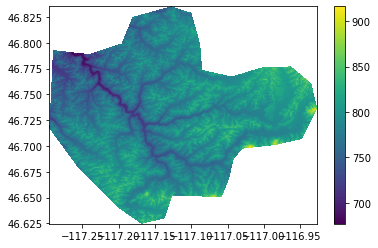

In [10]:
fig, ax = plt.subplots()
elev_ax = ax.pcolormesh(rast_x, rast_y, elev, shading='auto')
plt.colorbar(elev_ax, ax=ax)


### Prep the data for richdem, to analyze the slopes and aspects of the DEM

In [11]:
elev_rd = rd.rdarray(elev, no_data=np.nan) # Need to turn the elevations from a numpy array to an rdarray to handle the np.nan values
elev_rd.projection = elev_rio.crs
# Be careful!  The richdem geotransform has a different configuration than the rasterio transform.
    # The geotransform must be a tuple.
elev_rd.geotransform = (elev_rio.transform[2],
                        elev_rio.transform[0],
                        elev_rio.transform[1],
                        elev_rio.transform[5],
                        elev_rio.transform[3],
                        elev_rio.transform[4])

In [12]:
# slope = rd.TerrainAttribute(elev_rd, attrib='slope_riserun')
slope = rd.TerrainAttribute(elev_rd, attrib='slope_degrees')


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
[===================================               ] (70% - 0.2s - 1 threads)     ] (10% - 0.6s - 1 threads)

### Here's a simple function, direct from the rasterio documentation to transform a raster from one projection to another

In [13]:
# Instructions from https://rasterio.readthedocs.io/en/latest/topics/reproject.html#reprojecting-a-geotiff-dataset

def reproject_basic(input_file, output_file, dst_crs):
    '''
    Takes one raster file (input_file) and transforms it to a new crs identified by EPSG (as in dst_crs='EPSG:4326')
    and saves it as a new raster (output_file).
    '''
    import numpy as np
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    
    #Read in the input_file and prep it to be warped
    with rasterio.open(input_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Write out the output, reprojected file
        with rasterio.open(output_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


t Wall-time = 0.560797======================= ] (99% - 0.0s - 1 threads)


In [14]:
latitude = 46.7 # Approximate coordinates of Moscow in degrees
longitude = -117
EPSG = int(  32700 - ((np.sign(latitude)+1)/2 * 100) +  (np.floor((180+longitude)/6) + 1)  )

In [15]:
EPSG

32611

In [16]:
%pwd

'/Users/timb/syncs/OneDrive - University of Idaho/TEACHINGs/GEOG479_GIS_programming/GIS_programming_F21/weeks/wk07_rastersII'

In [17]:
reproject_basic('../../datasets/regional_dems/palouse_hills.tif',
                'palouse_hills_' + str(EPSG) + '.tif',
                'EPSG: ' + str(EPSG) )

### Read in the new, reprojected DEM

In [18]:
elev_rio_reproject = rio.open('palouse_hills_' + str(EPSG) + '.tif')
elev_reproject = elev_rio_reproject.read(1)
elev_reproject[elev_reproject<-1000] = np.nan


elev_rd_reproject = rd.rdarray(elev_reproject, no_data=np.nan) # Need to turn the elevations from a numpy array to an rdarray to handle the np.nan values
elev_rd_reproject.projection = elev_rio_reproject.crs
# Be careful!  The richdem geotransform has a different configuration than the rasterio transform.
    # The geotransform must be a tuple.
elev_rd_reproject.geotransform = (elev_rio_reproject.transform[2],
                        elev_rio_reproject.transform[0],
                        elev_rio_reproject.transform[1],
                        elev_rio_reproject.transform[5],
                        elev_rio_reproject.transform[3],
                        elev_rio_reproject.transform[4])


In [19]:
# Return information about the richdem geotransform, to ensure that it looks right
print(elev_rd_reproject.geotransform)

(477366.0719509967, 7.985279909359203, 0.0, 5186901.591923617, 0.0, -7.985279909359203)



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.546686======================= ] (99% - 0.0s - 1 threads)


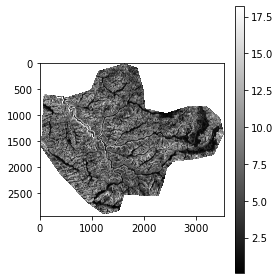

{'vmin': 0.11237697035074233, 'vmax': 18.19711265563963}

In [20]:
slope_reproject = rd.TerrainAttribute(elev_rd_reproject, attrib='slope_degrees')
rd.rdShow(slope_reproject)

In [21]:
slope_reproject.projection = elev_rio_reproject.crs
slope_reproject.geotransform = elev_rd_reproject.geotransform # Here, use the geotransform of the original data to be the geotransform of the new raster


<div class="alert alert-block alert-warning">

### What are the maximum and median slopes of the broader Palouse DEM?
How doe these compare with the slopes of the City of Moscow LiDAR DEM?
    
</div>


We can also use richdem to map the aspects of a DEM.  See https://richdem.readthedocs.io/en/latest/terrain_attributes.html

<div class="alert alert-block alert-warning">

### What are the typical orientations of the Palouse hills in this elevation data?
</div>

<div class="alert alert-block alert-warning">

### Are these orientations different than those for a random segment of mountain headwaters?
See datasets/regional_dems/st_joe_headwaters.tif
![Drag Racing](Dragster.jpg)
</div>

## Extracting raster data along a vector

In [ ]:
moscow_gdb_path = datasets_dir / 'moscow' / 'moscow_vectors' / 'Moscow.gdb'
print(moscow_gdb_path)
print(type(moscow_gdb_path))

moscow_gdb = str(moscow_gdb_path)

fiona.listlayers(moscow_gdb)
roads = gpd.read_file(moscow_gdb, layer='Centerlines')


In [ ]:
roads.crs